# Imports

In [11]:
import itertools

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from src.training import model_fit_layers, model_fit, FrozenSimpleRNN, leaky_relu, PredPriorLoss, SupervisedProjection, FFLossWithThreshold
from src.preproc import get_MNIST, get_BAIR, roving_oddball_preproc, statistical_learning_preproc, omission_preproc, BAIR_learning_preproc, random_omissions
from src.visualization import plot_input_series
from src.utils import save_results

In [13]:
EXP_DATA = {"Roving Oddball":get_MNIST,
            "Statistical Learning":get_MNIST,
            "Omission":get_MNIST,
            "Video Learning":get_BAIR,
}

EXP_PARADIGMS = {
    "Roving Oddball":roving_oddball_preproc,
    "Statistical Learning":statistical_learning_preproc,
    "Omission":omission_preproc,
    "Video Learning":BAIR_learning_preproc,
}

Y_RETURNS = {
    "Contrastive":"p_neg",
    "Predictive":"x",
    "Supervised":"y",
    "Untrained":"y",
}

TRAIN_SPLITS = {
    "Contrastive":0.5,
    "Predictive":0.,
    "Supervised":0.,
    "Untrained":0.,
}

TRAINING_FUNCTIONS = {
  True:model_fit_layers,
  False:model_fit
  }

RECURRENT_LAYERS = {
    True:tf.keras.layers.SimpleRNN,
    False:FrozenSimpleRNN,
}


ACTIVITY_REGULARIZERS = {
    True:tf.keras.regularizers.L2(1e-4),  # all but predictive prior: 1e-4
    False:None
}

KERNEL_REGULARIZERS = {
    True: tf.keras.regularizers.L2(1e-3),
    False: None
}


def CREATE_LOSS_FUNCTION(model, training_algorithm):
  if training_algorithm == "Contrastive":
    return FFLossWithThreshold(10., average=False)
  elif training_algorithm == "Predictive":
    return PredPriorLoss(model)
  elif training_algorithm == "Supervised":
    return SupervisedProjection(None, tf.reduce_prod(model.output_shape[2:]))
  elif training_algorithm == "Untrained":
      return None


def run_experiment(exp_paradigm="Roving Oddball", training_algorithm="Predictive", localized=False, recurrence=True, control_gain=True, enforce_sparsity=True):

  # load the dataset
  train_dataset, val_dataset = EXP_DATA[exp_paradigm]()
    
  # load the validation data (only to build the model)
  for x, y in val_dataset.batch(4).take(1):
    x, y = EXP_PARADIGMS[exp_paradigm](x, y, TRAIN_SPLITS[training_algorithm], Y_RETURNS[training_algorithm])

  # define the model
  model = tf.keras.Sequential([
      tf.keras.layers.Reshape([len(x[0]), -1]),
      tf.keras.layers.Normalization(),
      RECURRENT_LAYERS[recurrence](512, activation=leaky_relu, return_sequences=True, unroll=True, kernel_regularizer=KERNEL_REGULARIZERS[enforce_sparsity],
        recurrent_initializer="glorot_uniform", activity_regularizer=ACTIVITY_REGULARIZERS[control_gain]),
      tf.keras.layers.Normalization(),
      RECURRENT_LAYERS[recurrence](128, activation=leaky_relu, return_sequences=True, unroll=True, kernel_regularizer=KERNEL_REGULARIZERS[enforce_sparsity],
        recurrent_initializer="glorot_uniform", activity_regularizer=ACTIVITY_REGULARIZERS[control_gain]),
      ])

  # build and compile model
  model.build(x.shape)
  model(x)
  model.compile(loss=CREATE_LOSS_FUNCTION(model, training_algorithm),
                optimizer=tf.keras.optimizers.Adam())
  print(model.summary())

    
  # define train and test data
  train_data = train_dataset.shuffle(3000).batch(512).map(lambda x,y:EXP_PARADIGMS[exp_paradigm](x, y, TRAIN_SPLITS[training_algorithm], Y_RETURNS[training_algorithm]))
  val_data = val_dataset.batch(512).map(lambda x,y:EXP_PARADIGMS[exp_paradigm](x, y, TRAIN_SPLITS[training_algorithm], Y_RETURNS[training_algorithm]))

  if training_algorithm == "Untrained":
      model(x)  # call once to make sure everything is initiated properly
      pass
  else:
      # train model
      TRAINING_FUNCTIONS[localized](model, train_data, validation_data=val_data, epochs=25)

  # save results
  save_results(model, exp_paradigm, training_algorithm, localized, recurrence, control_gain, enforce_sparsity,
               save_dir=save_dir)

## EXPERIMENT TIME!

In [14]:
# run experiment tester
exp_paradigm="Video Learning"
training_algorithm="Supervised"
localized=False
recurrence=True
control_gain=False
enforce_sparsity=False

# save the results to:
save_dir = "/home/guetlid95/projects/pc_algos_study_1/results/revision_results/flip_each_t"

2025-05-28 10:56:43.181217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2025-05-28 10:56:43.181751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


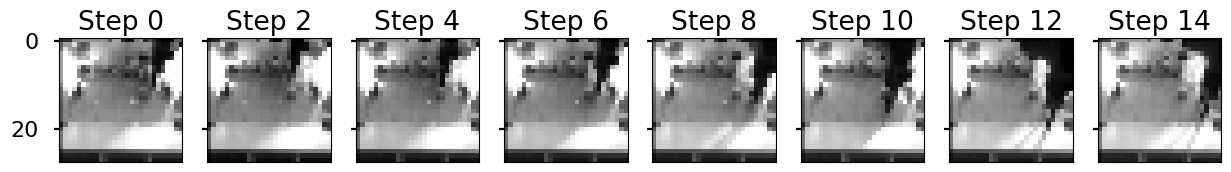

In [15]:
# plot a data example
train_dataset, val_dataset = EXP_DATA[exp_paradigm]()
for x, y in val_dataset.batch(16).take(1):
    x, y = EXP_PARADIGMS[exp_paradigm](x, y, TRAIN_SPLITS[training_algorithm], Y_RETURNS[training_algorithm])

plot_input_series(x, sample_idx=0, show_indices=[0, 2, 4, 6, 8, 10, 12, 14])

In [ ]:
# run experiment tester
print("RUNNING: ", (exp_paradigm, training_algorithm, localized, recurrence, control_gain, enforce_sparsity))
run_experiment(exp_paradigm, training_algorithm, localized, recurrence, control_gain, enforce_sparsity)
print("DONE")

RUNNING:  ('Video Learning', 'Supervised', False, True, False, False)


2025-05-28 10:56:44.727439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2025-05-28 10:56:44.727991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (4, 16, 784)              0         
                                                                 
 normalization_2 (Normalizat  (4, 16, 784)             1569      
 ion)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (4, 16, 512)              664064    
                                                                 
 normalization_3 (Normalizat  (4, 16, 512)             1025      
 ion)                                                            
                                                                 
 simple_rnn_3 (SimpleRNN)    (4, 16, 128)              82048     
                                                                 
Total params: 748,706
Trainable params: 746,112
Non-tr

2025-05-28 10:56:45.557010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [256]
	 [[{{node Placeholder/_4}}]]
2025-05-28 10:56:45.557604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [256]
	 [[{{node Placeholder/_1}}]]
2025-05-28 10:56:55.705081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1385 of 3000
2025-05-28 10:57:05.816167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2928 of 3000
2025-05-28 10:5

27/85 [========>.....................] - ETA: 4:26 - loss: 1.3761

In [ ]:
for condition in [i for i in itertools.product(["Video Learning"],  # , "Statistical Learning"],  # EXP_PARADIGMS.keys(),
                                   Y_RETURNS.keys(),
                                   TRAINING_FUNCTIONS.keys(),
                                   [True],
                                   [False],
                                   [False]  # KERNEL_REGULARIZERS.keys()
                                   ) if not (i[1]=="Supervised" and i[2]==True)]:
  print("RUNNING: ", condition)
  #run_experiment('Video Learning', 'Predictive Prior', True, True, False, False)
  #print("DONE")